# 1.Brief description of the problem and data

In this project, I explored the use of CycleGAN, a variant of Generative Adversarial Networks (GANs), to recreate the unique style of Claude Monet in photos or generate new images in his style. CycleGAN can learn a mapping between two domains of images without requiring paired training data, which makes it a popular choice for image-to-image translation tasks such as painting style transfer. In this competition, the goal was to generate 7,000 to 10,000 Monet-style images using GANs or CycleGANs. I studied the dataset, preprocessed it, trained CycleGAN models, and evaluated the results. Through this project, I gained experience in computer vision, deep learning, and CycleGANs. Data are available at: https://www.kaggle.com/competitions/gan-getting-started/data

### Import necessary packages

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import PIL
from kaggle_datasets import KaggleDatasets

from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import Input, Conv2D, Activation
from tensorflow.keras.models import Sequential

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()

AUTOTUNE = tf.data.experimental.AUTOTUNE

# 2. Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

In [3]:
GCS_PATH = KaggleDatasets().get_gcs_path()

MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))
PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(PHOTO_FILENAMES))

img_width = 256
img_height = 256
batch_size = 16
channels = 3

Monet TFRecord Files: 5
Monet TFRecord Files: 20


get_gcs_path is not required on TPU VMs which can directly use Kaggle datasets, using path: /kaggle/input/gan-getting-started


# 3. Model Architecture

### Image processing

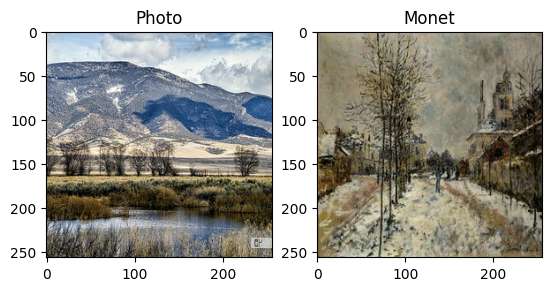

In [4]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*[img_width, img_height], 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def data_augment(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_hue(image, max_delta=0.05)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    return image
    return tf.image.random_crop(image, size=[img_width, img_height, 3])

def load_dataset(filenames, labeled=True, ordered=False, augment=True):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    if augment:
        dataset = dataset.map(data_augment, num_parallel_calls=AUTOTUNE)
        dataset = dataset.repeat(count=2)
    return dataset

monet_img = load_dataset(MONET_FILENAMES, labeled=True, augment=True).batch(1)
photo_img = load_dataset(PHOTO_FILENAMES, labeled=True, augment=True).batch(1)
example_monet = next(iter(monet_img))
example_photo = next(iter(photo_img))
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)
plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)
plt.show()

### define models

In [5]:
def create_downsample_block(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    block = keras.Sequential([
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                               kernel_initializer=initializer, use_bias=False),
        tfa.layers.InstanceNormalization(gamma_initializer=gamma_init) if apply_instancenorm else None,
        tf.keras.layers.LeakyReLU()
    ])
    return block

def create_upsample_block(filters, size, apply_dropout=False):
    init = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    dropout_rate = 0.5 if apply_dropout else 0.0

    block = keras.Sequential([
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                         padding='same',
                                         kernel_initializer=init,
                                         use_bias=False),
        tfa.layers.InstanceNormalization(gamma_initializer=gamma_init),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.ReLU()
    ])
    return block

def create_generator(image_shape=(img_width, img_height, 3)):
    input_layer = keras.layers.Input(shape=image_shape)

    downsample_filters = [64, 128, 256, 512, 512, 512, 512, 512]
    downsample_sizes = [4, 4, 4, 4, 4, 4, 4, 4]
    downsample_instancenorms = [False, True, True, True, True, True, True, True]
    down_stack = [create_downsample_block(filters, size, instancenorm) for filters, size, instancenorm in 
                  zip(downsample_filters, downsample_sizes, downsample_instancenorms)]

    upsample_filters = [512, 512, 512, 512, 256, 128, 64]
    upsample_sizes = [4, 4, 4, 4, 4, 4, 4]
    upsample_dropouts = [True, True, True, False, False, False, False]
    up_stack = [create_upsample_block(filters, size, dropout) for filters, size, dropout in 
                zip(upsample_filters, upsample_sizes, upsample_dropouts)]

    initializer = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    output_layer = keras.layers.Conv2DTranspose(channels, 4, strides=2, padding='same',
                                         kernel_initializer=initializer, activation='tanh')

    x = input_layer
    skip_connections = []
    for down_block in down_stack:
        x = down_block(x)
        skip_connections.append(x)
    
    skip_connections = list(reversed(skip_connections[:-1]))
    for up_block, skip_connection in zip(up_stack, skip_connections):
        x = up_block(x)
        x = keras.layers.Concatenate()([x, skip_connection])

    x = output_layer(x)
    model = keras.models.Model(input_layer, x)
    model.summary()
    return model


In [6]:
def create_discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    x = inp
    for filters in [64, 128, 256]:
        x = downsample(filters, 4)(x)
    x = tf.keras.layers.ZeroPadding2D()(x)
    x = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.ZeroPadding2D()(x)
    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(x)
    return tf.keras.Model(inputs=inp, outputs=last)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 128, 128, 64  3072        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 sequential_1 (Sequential)      (None, 64, 64, 128)  131328      ['sequential[0][0]']             
                                                                                              

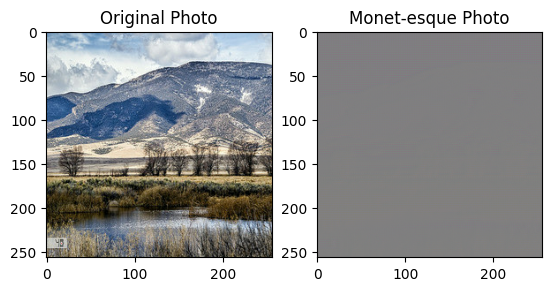

In [7]:
with strategy.scope():
    gen_M = create_generator()
    gen_P = create_generator()
    disc_M = create_discriminator()
    disc_P = create_discriminator()

def show_generator():
    example_monet = next(iter(monet_img))
    example_photo = next(iter(photo_img))
    to_monet = gen_M(example_photo)
    plt.subplot(1, 2, 1)
    plt.title("Original Photo")
    plt.imshow(example_photo[0] * 0.5 + 0.5)

    plt.subplot(1, 2, 2)
    plt.title("Monet-esque Photo")
    plt.imshow(to_monet[0] * 0.5 + 0.5)
    plt.show()

show_generator()

In [8]:
class CycleGan(keras.Model):
    def __init__(self, monet_generator, photo_generator, monet_discriminator, photo_discriminator,lambda_cycle=10):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle    
    def compile(self,m_gen_optimizer,p_gen_optimizer,m_disc_optimizer,p_disc_optimizer,gen_loss_fn,
        disc_loss_fn,cycle_loss_fn,identity_loss_fn):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data        
        with tf.GradientTape(persistent=True) as tape:
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)
        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))
        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))
        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))       
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In [9]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
        total_disc_loss = real_loss + generated_loss
        return total_disc_loss * 0.5
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        return LAMBDA * tf.reduce_mean(tf.abs(real_image - cycled_image))
    def identity_loss(real_image, same_image, LAMBDA):
        return LAMBDA * 0.5 * tf.reduce_mean(tf.abs(real_image - same_image))

    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    
    cycle_gan_model = CycleGan(
        gen_M, gen_P, disc_M, disc_P
    )
    
    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [10]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_img, photo_img)),
    epochs=1
)

2023-05-02 01:59:16.126002: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-05-02 01:59:17.798687: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


600/600 [==============================] - 206s 132ms/step - monet_gen_loss: 4.4010 - photo_gen_loss: 4.5457 - monet_disc_loss: 0.6482 - photo_disc_loss: 0.6180


In [11]:
! mkdir ../images

# 4. Result

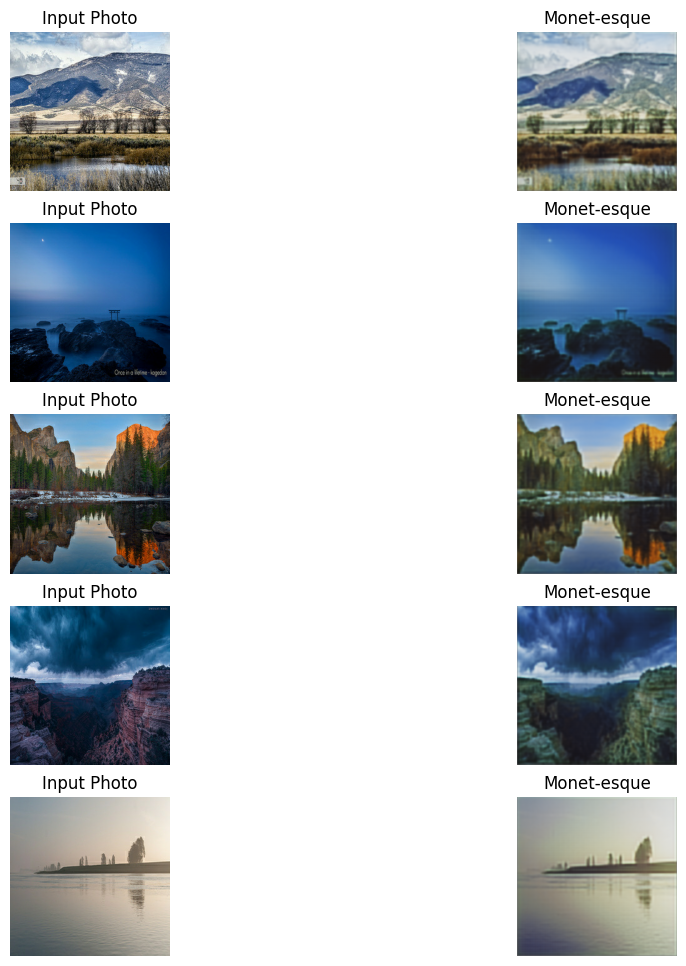

4656it [21:16,  3.44it/s]

In [ ]:
_, ax = plt.subplots(3, 2, figsize=(12, 12))
for i, img in enumerate(photo_img.take(3)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()


In [15]:
# i = 1
# from tqdm import tqdm
# for img in tqdm(photo_img):
#     prediction = monet_generator(img, training=False)[0].numpy()
#     prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
#     im = PIL.Image.fromarray(prediction)
#     im.save("../images/" + str(i) + ".jpg")
#     i += 1

In [14]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'